In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_06cMagda import *

In [3]:
mnist_bunch = quick_mnist_data()

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, numdim, mom=0.1, eps=1e-5):
        super(BatchNorm, self).__init__()
        self.mom = mom
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(1, numdim))
        self.bias = nn.Parameter(torch.zeros(1, numdim))
        self.register_buffer('running_means', torch.tensor([0.]))
        self.register_buffer('running_vars', torch.tensor([0.]))
        
    def forward(self, x):
        if self.training:
            means = x.mean(dim=0, keepdims=True)
            vars_ = x.var(dim=0, keepdims=True)
            with torch.no_grad():
                self.running_means = (1-self.mom) * self.running_means + self.mom * means if (self.running_means != 0.).all() else means
                self.running_vars = (1-self.mom) * self.running_vars + self.mom * vars_ if (self.running_vars != 0.).all() else vars_
        else:
            means = self.running_means
            vars_ = self.running_vars
        x = (x - means) / (vars_ + self.eps)**0.5
        return self.weight * x + self.bias        

In [5]:
class LearnerBatchNorm(Learner):
#     def __init__(self, data_bunch, callback_list=[]):
#         super(LearnerBatchNorm, self).__init__(data_bunch, callback_list=[])
    
    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), BatchNorm(num_hidden), nn.Linear(num_hidden, num_out))


In [6]:
device = torch.device('cuda')
cb_list = [CudaCallback(device), LossCallback(), AccuracyCallback()]
learner_batch = LearnerBatchNorm(mnist_bunch, cb_list)

In [7]:
learner_batch.fit(5)

train:  0.1471092253923416 validation:  0.16714395582675934
train:  0.09236131608486176 validation:  0.12649759650230408
train:  0.07914262264966965 validation:  0.11824730038642883
train:  0.10652434080839157 validation:  0.10666941851377487
train:  0.07405215501785278 validation:  0.10694549232721329
Final accuracy: 0.970100


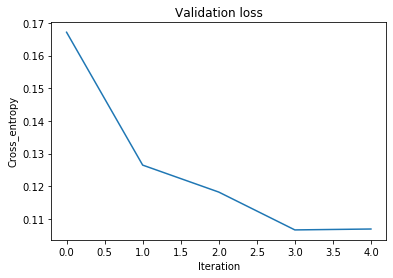

In [8]:
learner_batch.plot_validation_loss()

In [9]:
cb_list.append(HooksCallback(OutputStatsHook))
learner_batch = LearnerBatchNorm(mnist_bunch, cb_list)
learner_batch.fit(5)

train:  0.1877623051404953 validation:  0.19582313299179077
train:  0.2526068389415741 validation:  0.145766943693161
train:  0.07463880628347397 validation:  0.11300477385520935
train:  0.06785057485103607 validation:  0.10992038249969482
train:  0.08446736633777618 validation:  0.10372211039066315
Final accuracy: 0.970300


Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): BatchNorm()
  (3): Linear(in_features=50, out_features=10, bias=True)
)


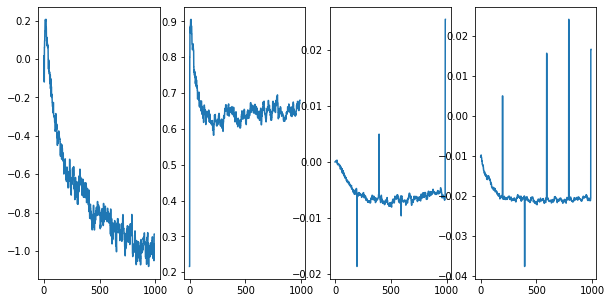

In [10]:
fig = plt.figure(figsize=(10, 5))
for lidx, layer in enumerate(learner_batch.model.children()):
    ax = fig.add_subplot(1, 4, lidx+1)
    ax.plot(layer.output_stats['means'])
print(learner_batch.model)

In [11]:
learner = Learner(mnist_bunch, cb_list)
learner.fit(5)

train:  0.2713852524757385 validation:  0.22500832378864288
train:  0.27981528639793396 validation:  0.18792448937892914
train:  0.19919084012508392 validation:  0.18641531467437744
train:  0.09303155541419983 validation:  0.14855434000492096
train:  0.11258632689714432 validation:  0.1481524258852005
Final accuracy: 0.955200


Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)


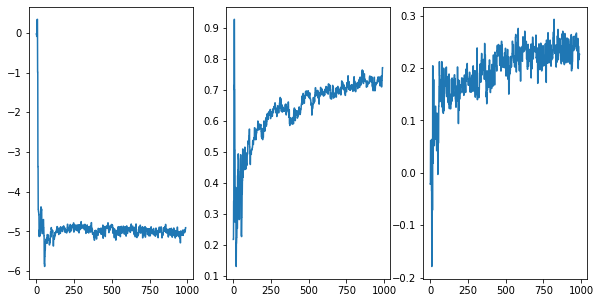

In [12]:
fig = plt.figure(figsize=(10, 5))
for lidx, layer in enumerate(learner.model.children()):
    ax = fig.add_subplot(1, 3, lidx+1)
    ax.plot(layer.output_stats['means'])
print(learner.model)

In [13]:
class LearnerBN(Learner):
    
    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), nn.BatchNorm1d(num_hidden), nn.Linear(num_hidden, num_out))


In [14]:
learner_bn = LearnerBN(mnist_bunch, cb_list)
learner_bn.fit(5)

train:  0.18325015902519226 validation:  0.17314401268959045
train:  0.16107583045959473 validation:  0.12956355512142181
train:  0.08219682425260544 validation:  0.11057333648204803
train:  0.07408495992422104 validation:  0.11832769960165024
train:  0.09096239507198334 validation:  0.10357602685689926
Final accuracy: 0.969300


Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=50, out_features=10, bias=True)
)


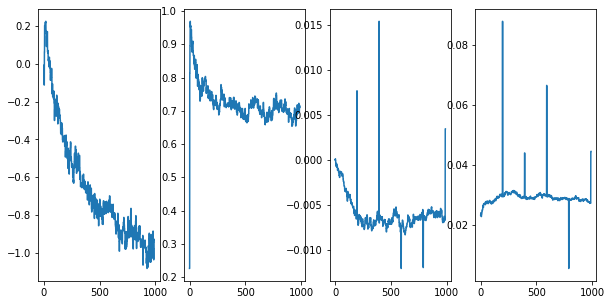

In [15]:
fig = plt.figure(figsize=(10, 5))
for lidx, layer in enumerate(learner_bn.model.children()):
    ax = fig.add_subplot(1, 4, lidx+1)
    ax.plot(layer.output_stats['means'])
print(learner_bn.model)

In [22]:
class BatchNormCnn(nn.Module):
    def __init__(self, numchannels, mom=0.1, eps=1e-5):
        super(BatchNormCnn, self).__init__()
        self.mom = mom
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(1, numchannels, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, numchannels, 1, 1))
        self.register_buffer('running_means', torch.tensor([0.]))
        self.register_buffer('running_vars', torch.tensor([0.]))
        
    def forward(self, x):
        if self.training:
            means = x.mean(dim=(0, 2, 3), keepdims=True)
            vars_ = x.var(dim=(0, 2, 3), keepdims=True)
            with torch.no_grad():
                self.running_means = (1-self.mom) * self.running_means + self.mom * means if (self.running_means != 0.).all() else means
                self.running_vars = (1-self.mom) * self.running_vars + self.mom * vars_ if (self.running_vars != 0.).all() else vars_
        else:
            means = self.running_means
            vars_ = self.running_vars
        x = (x - means) / (vars_ + self.eps)**0.5
        return self.weight * x + self.bias   

In [23]:
class LearnerCnnBn(Learner):
    def _get_model(self, num_out=10):
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), BatchNormCnn(8),
            nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), BatchNormCnn(16),
            nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), BatchNormCnn(32),
            nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(), BatchNormCnn(64),
            nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(), BatchNormCnn(64),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(64, num_out)
        )

In [24]:
cb_list = [CudaCallback(device), ReshapeMnist(), LossCallback(), AccuracyCallback(), HooksCallback(OutputStatsHook)]
learner_cnn = LearnerCnnBn(mnist_bunch, cb_list)
learner_cnn.fit(5)

train:  0.09581054002046585 validation:  0.1242501363158226
train:  0.020900890231132507 validation:  0.05735502392053604
train:  0.027981022372841835 validation:  0.05412640422582626
train:  0.026691246777772903 validation:  0.04314583167433739
train:  0.036345601081848145 validation:  0.04765917733311653
Final accuracy: 0.985300


Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): BatchNormCnn()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNormCnn()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNormCnn()
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNormCnn()
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU()
  (14): BatchNormCnn()
  (15): AdaptiveAvgPool2d(output_size=1)
  (16): Flatten()
  (17): Linear(in_features=64, out_features=10, bias=True)
)


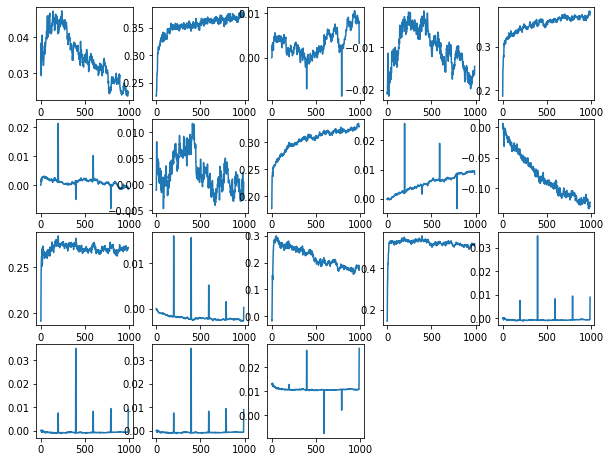

In [28]:
fig = plt.figure(figsize=(10, 10))
for lidx, layer in enumerate(learner_cnn.model.children()):
    ax = fig.add_subplot(5, 5, lidx+1)
    ax.plot(layer.output_stats['means'])
print(learner_cnn.model)

In [ ]:
nb_auto_export()